# Binary Classification with a Bank

Muh Amri Sidiq

## Introdiction

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Bank Marketing Dataset dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance

## Install Library

In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import optuna
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load, Read Data and Understanding

In [2]:
%%time

train = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')

CPU times: user 2.11 s, sys: 574 ms, total: 2.68 s
Wall time: 3.45 s


Read data preview

In [3]:
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


Insight: data have 75000 row and 18 column

In [5]:
test.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         250000 non-null  int64 
 1   age        250000 non-null  int64 
 2   job        250000 non-null  object
 3   marital    250000 non-null  object
 4   education  250000 non-null  object
 5   default    250000 non-null  object
 6   balance    250000 non-null  int64 
 7   housing    250000 non-null  object
 8   loan       250000 non-null  object
 9   contact    250000 non-null  object
 10  day        250000 non-null  int64 
 11  month      250000 non-null  object
 12  duration   250000 non-null  int64 
 13  campaign   250000 non-null  int64 
 14  pdays      250000 non-null  int64 
 15  previous   250000 non-null  int64 
 16  poutcome   250000 non-null  object
dtypes: int64(8), object(9)
memory usage: 32.4+ MB


Insight: data have 25000 row and 17 column

check missing values all data

In [7]:
train.isna().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [8]:
test.isna().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

Insight: data train and data test no have missing values

## Exploratory Data Analysis
Exploratory Data Analysis (EDA) is the process of analyzing and summarizing datasets to understand their main characteristics before applying machine learning models or statistical tests. EDA helps identify patterns, detect anomalies, check assumptions, and gain insights using visualizations and statistical methods

In [9]:
train.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


Insight: `balance` has anomaly with value is minus

In [10]:
train.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome
count,750000,750000,750000,750000,750000,750000,750000,750000,750000
unique,12,3,4,2,2,2,3,12,4
top,management,married,secondary,no,yes,no,cellular,may,unknown
freq,175541,480759,401683,737151,411288,645023,486655,228411,672450


Insight: All type data object no have balance proportion 

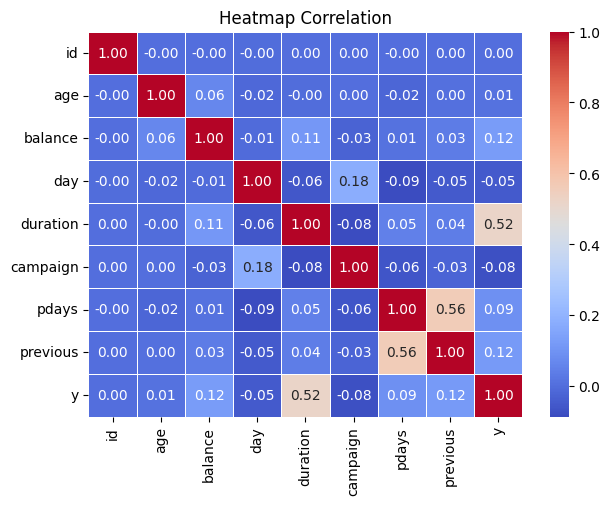

In [11]:
bank_numeric = train.select_dtypes(include=['number'])

# Calculate correlation
corr_matrix = bank_numeric.corr()

# Plot heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Correlation")
plt.show()

Insight: `duration` have storng correlation with `y`, and `pdays` have strong correlation with `previous`

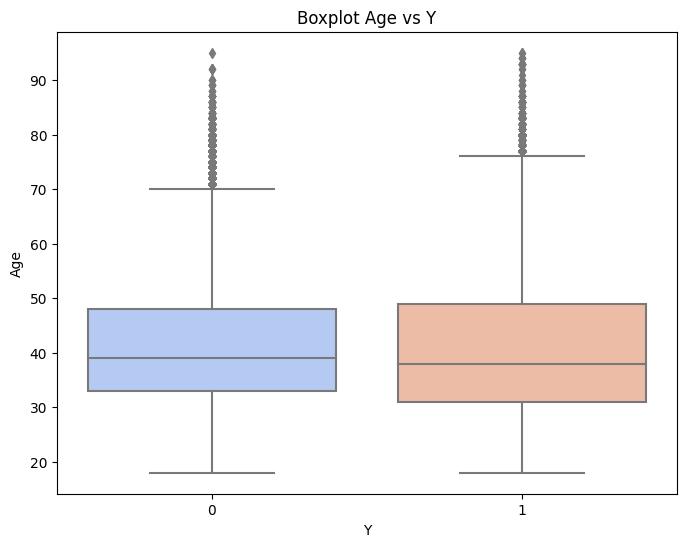

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train['y'], y=train['age'], palette='coolwarm')
plt.xlabel('Y')
plt.ylabel('Age')
plt.title('Boxplot Age vs Y')
plt.show()

Insight: `y` type 1 have higher outliers

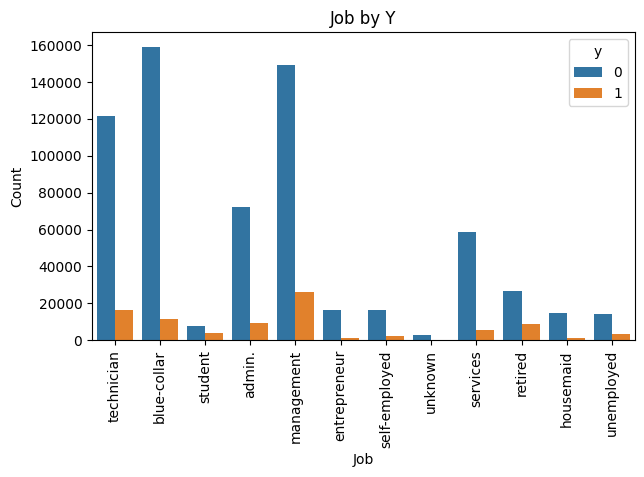

In [13]:
plt.figure(figsize=(7, 4))
sns.countplot(x='job', hue='y', data=train)
plt.title('Job by Y')
plt.xlabel('Job')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Insight: `job` blue-colar have highest `y` type 0 and lowest is unknown, `job` management have highest `y` type 1 and lowest is unknown.

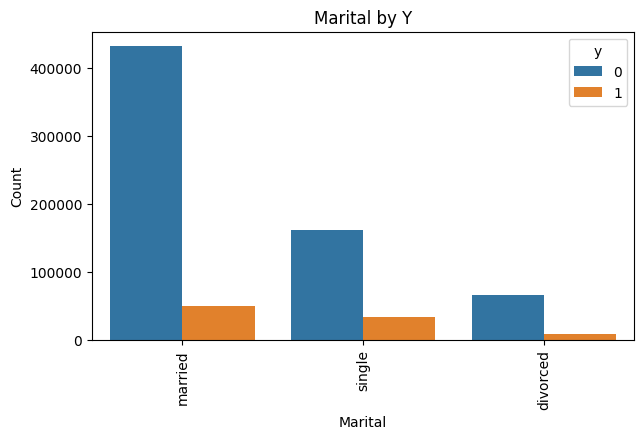

In [14]:
plt.figure(figsize=(7, 4))
sns.countplot(x='marital', hue='y', data=train)
plt.title('Marital by Y')
plt.xlabel('Marital')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Insight: `marital` type married have highest `y` type 1 & 0 and `marital` type divorced have lowest `y` type 1 & 0 

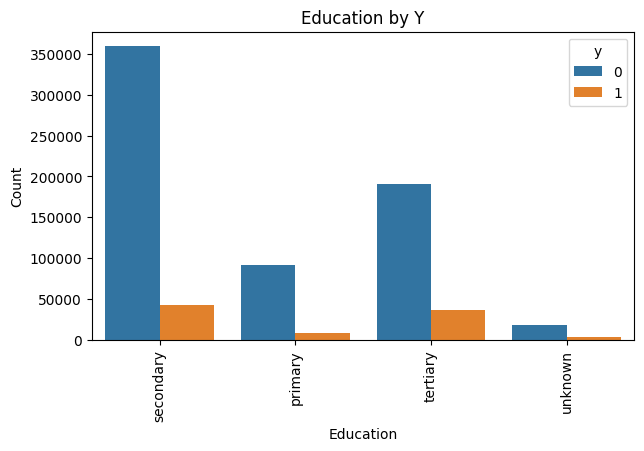

In [15]:
plt.figure(figsize=(7, 4))
sns.countplot(x='education', hue='y', data=train)
plt.title('Education by Y')
plt.xlabel('Education')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Insight: `education` type secondary have highest `y` type 1 & 0 and `education` type unknown have lowest `y` type 1 & 0 

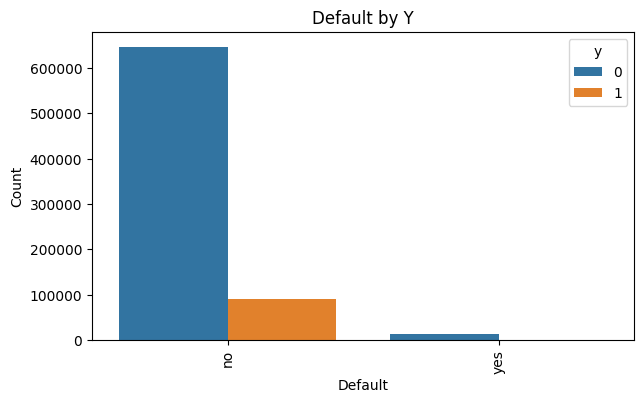

In [16]:
plt.figure(figsize=(7, 4))
sns.countplot(x='default', hue='y', data=train)
plt.title('Default by Y')
plt.xlabel('Default')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Insight: `deafult` type no have highest `y` type 0 and `default` type yes no have `y` type 1

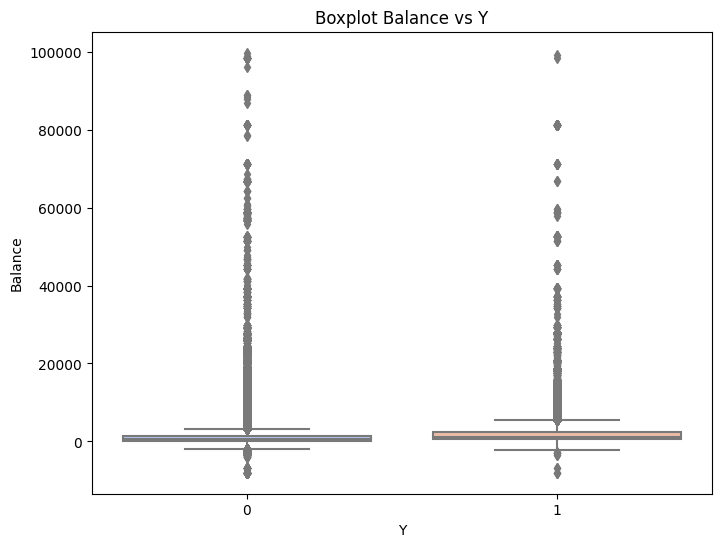

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train['y'], y=train['balance'], palette='coolwarm')
plt.xlabel('Y')
plt.ylabel('Balance')
plt.title('Boxplot Balance vs Y')
plt.show()

Insight: Two type `y` have outliers, and two type `y` have `balance` minus

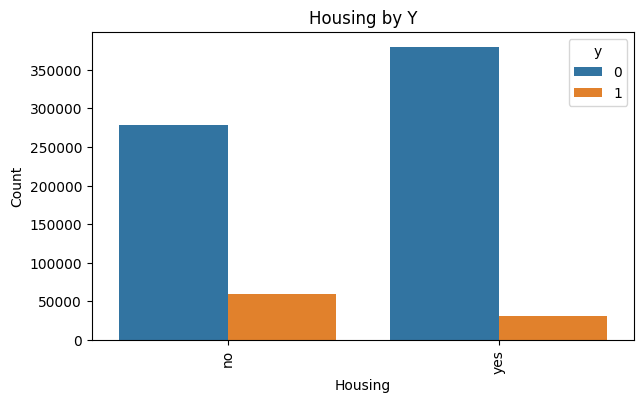

In [18]:
plt.figure(figsize=(7, 4))
sns.countplot(x='housing', hue='y', data=train)
plt.title('Housing by Y')
plt.xlabel('Housing')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Insight: `housing` type yes have highest `y` type 0 and `housing` type yes have lowest `y` type 1 

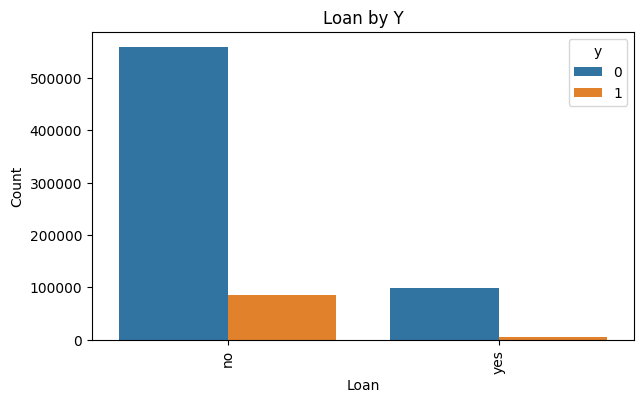

In [19]:
plt.figure(figsize=(7, 4))
sns.countplot(x='loan', hue='y', data=train)
plt.title('Loan by Y')
plt.xlabel('Loan')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Insight: `loan` type no have highest `y` type 0 and `loan` type yes have lowest `y` type 1

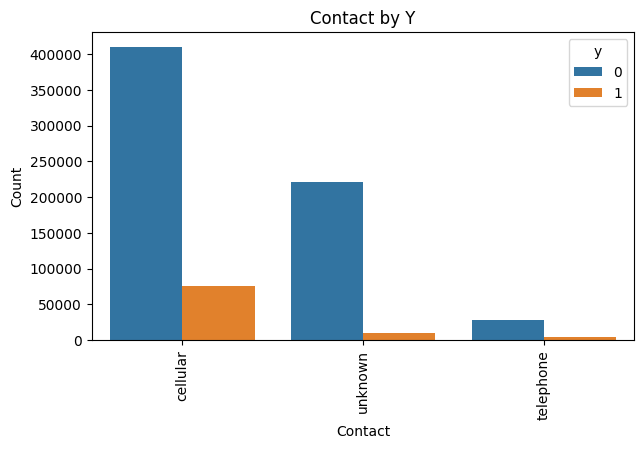

In [20]:
plt.figure(figsize=(7, 4))
sns.countplot(x='contact', hue='y', data=train)
plt.title('Contact by Y')
plt.xlabel('Contact')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Insight: `contact` type cellular have highest count `y` type 0 and `contact` type cellular have lowest count `y` type 1

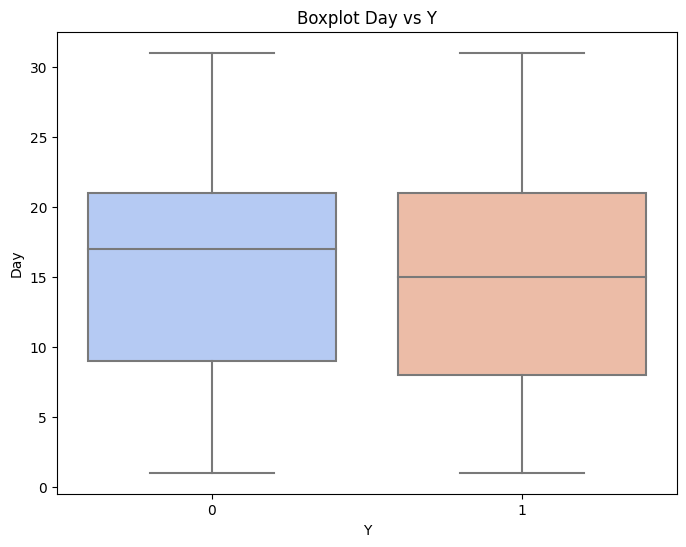

In [21]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train['y'], y=train['day'], palette='coolwarm')
plt.xlabel('Y')
plt.ylabel('Day')
plt.title('Boxplot Day vs Y')
plt.show()

Insight: `y` type 0 have highest median `day` than others

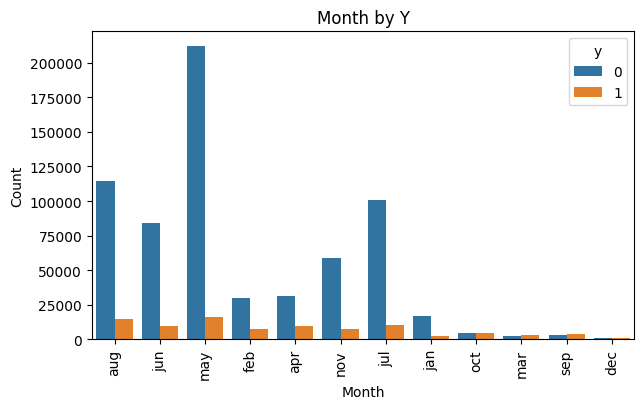

In [22]:
plt.figure(figsize=(7, 4))
sns.countplot(x='month', hue='y', data=train)
plt.title('Month by Y')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Insight: `month` may have highest `y` type 0 and `month` dec have lowest `y` type 0 & 1

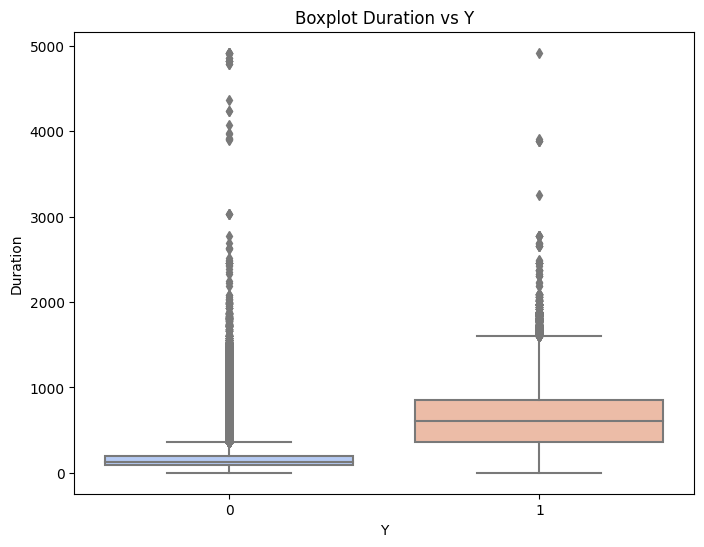

In [23]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train['y'], y=train['duration'], palette='coolwarm')
plt.xlabel('Y')
plt.ylabel('Duration')
plt.title('Boxplot Duration vs Y')
plt.show()

Insight: `y` type 1 have highest median `duration`

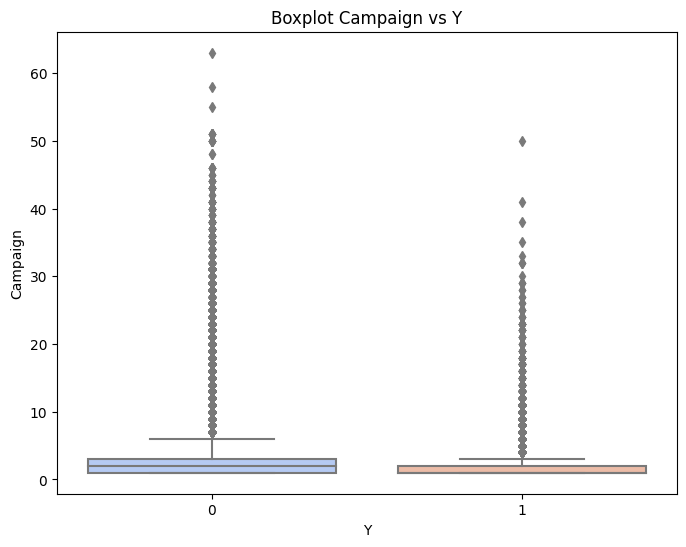

In [24]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train['y'], y=train['campaign'], palette='coolwarm')
plt.xlabel('Y')
plt.ylabel('Campaign')
plt.title('Boxplot Campaign vs Y')
plt.show()

Insight: `y` type 0 have median highest count `campaign`

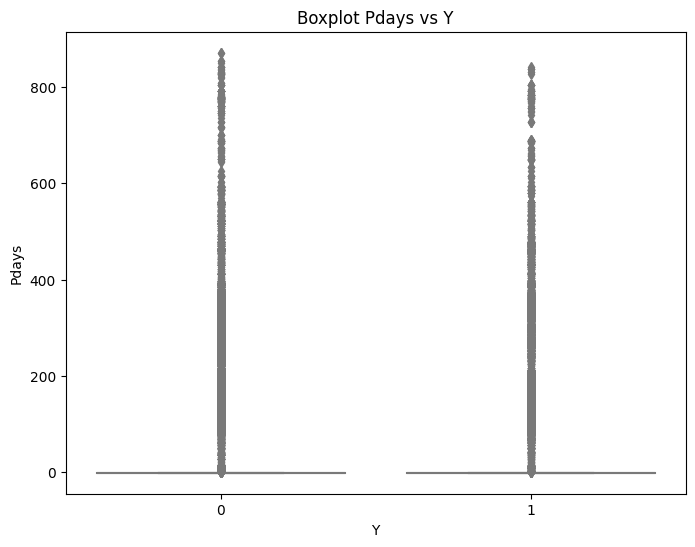

In [25]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train['y'], y=train['pdays'], palette='coolwarm')
plt.xlabel('Y')
plt.ylabel('Pdays')
plt.title('Boxplot Pdays vs Y')
plt.show()

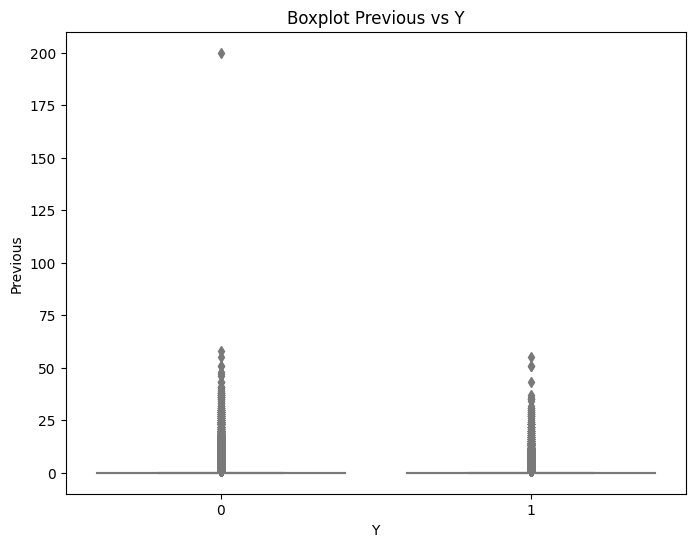

In [26]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train['y'], y=train['previous'], palette='coolwarm')
plt.xlabel('Y')
plt.ylabel('Previous')
plt.title('Boxplot Previous vs Y')
plt.show()

Insight: `y` type 0 have outliers highest `previous` 

In [27]:
train['y'].value_counts()

y
0    659512
1     90488
Name: count, dtype: int64

Insight: Target `y` not balance

## Preparation Data

Change type data

In [28]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
le = LabelEncoder()

for col in cat_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])

In [29]:
X = train.drop(['y', 'id'], axis=1)
y = train['y']

test_final = test.drop('id', axis=1)

## Modeling

In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in kf.split(X):
    x_train, x_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [31]:
model = XGBClassifier(
    n_estimators=2000,
    max_depth=15,
    learning_rate=0.001,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=101
)

# Train model
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000,
              n_jobs=None, num_parallel_tree=None, random_state=101, ...)

<Figure size 1000x600 with 0 Axes>

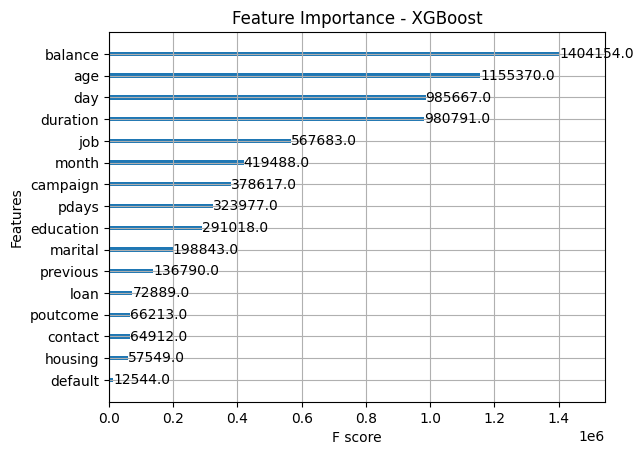

In [32]:
# Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight')
plt.title("Feature Importance - XGBoost")
plt.show()

In [33]:
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]

print("Accuracy of Conversion Prediction Model:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Report Classification:")
print(classification_report(y_test, y_pred))

Accuracy of Conversion Prediction Model: 0.93166
AUC Score: 0.9661625682351391
Report Classification:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    132018
           1       0.81      0.56      0.66     17982

    accuracy                           0.93    150000
   macro avg       0.88      0.77      0.81    150000
weighted avg       0.93      0.93      0.93    150000



## Prediction & Submission

In [34]:
y_pred_proba = model.predict_proba(test_final)[:, 1]

submission = pd.DataFrame({
    'id': sample['id'],         
    'y': y_pred_proba           
})

submission.to_csv("submission.csv", index=False)
submission.head()

,id,y
0,750000,0.033266
1,750001,0.134078
2,750002,0.034110
3,750003,0.026290
4,750004,0.063069


## Contact

[Linkedin](http://linkedin.com/in/muh-amri-sidiq)